<a href="https://colab.research.google.com/github/gc2321/3235-Machine-Learning/blob/main/lung/lung_mirna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introduction**

Lung cancer, a complex disease, is broadly categorized into two main types: small cell lung cancer (SCLC) and non-small cell lung cancer (NSCLC).

SCLC typically originates in the bronchi, rapidly proliferating and swiftly spreading to areas like the lymph nodes. Accounting for less than 20% of lung cancer cases, SCLC is strongly associated with tobacco smoking. SCLC is highly aggressive and frequently metastasizes, and as such, only about a quarter of patients achieve remission.

NSCLC comprises 80-90% of lung cancer diagnoses and tends to progress more gradually. Often asymptomatic initially, NSCLC develops slowly, leading to delayed detection; approximately 75% of cases are diagnosed at advanced stages. Surgery is a viable option for early-stage patients, while those in later stages typically undergo chemotherapy and radiation therapy.

In this study, I use cell line data (miRNA expression) from the Depmap Portal (depmap.org) to compare the profiles of SCLC and NSCLC. This set comprise 119 NSCLC and 49 SCLC cell lines, with a total of 743 features. We demonstrate the robust classification ability of these features, achieving an f1 score as 0.94 and 0.84 for Non-Small Cell Lung Cancer and Small Cell Lung Cancer, respectively. Moreover, there is distinct expression profiles of numerous miRNAs across these cell lines, shedding light on potential molecular mechanisms underlying lung cancer subtypes.

This work identifies distinct miRNA profiles in SCLC and NSCLC, which may play important roles in the mechanisms of these diseases.


In this work, we obtained cell line profiling data (miRNA expression and metabolomics) from the Depmap Portal (depmap.org) for 119 non-small cell lung cancer cell lines and 49 small cell lung cancer cell lines. In total, there are 959 features. We have shown that these features enable the classification of these cell lines with an f1 score of >0.9. Furthermore, we report distinct expression profiles of several miRNAs and metabolites in these cell lines.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(42)

## **Load Data and Preprocess Data**

In [2]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import fileinput
filePath ="/content/gdrive/MyDrive/lung/miRNA_lung.csv"

In [4]:
import pandas as pd
data = pd.read_csv(filePath)

In [5]:
data.head(3)

,depmap_id,cell_line_display_name,lineage_1,lineage_2,lineage_3,lineage_5,lineage_6,lineage_4,MIMAT0000062,MIMAT0000063,...,MIMAT0002192,MIMAT0002191,MIMAT0002190,MIMAT0002189,MIMAT0002188,MIMAT0002187,MIMAT0002186,MIMAT0002185,MIMAT0010151,MIMAT0010150
0,ACH-000382,CORL24,Lung,Lung Neuroendocrine Tumor,Small Cell Lung Cancer,NaN,NaN,NaN,14.735474,12.091720,...,6.113534,6.609991,6.308885,6.262471,6.397461,5.966938,5.907852,6.572435,6.230741,6.910133
1,ACH-000187,CORL311,Lung,Lung Neuroendocrine Tumor,Small Cell Lung Cancer,NaN,NaN,NaN,14.088938,10.298567,...,5.892877,6.482203,6.258330,6.425761,6.454340,6.050284,5.829088,6.321567,5.973841,6.723558
2,ACH-000695,CORL47,Lung,Lung Neuroendocrine Tumor,Small Cell Lung Cancer,NaN,NaN,NaN,14.802760,12.660535,...,5.856488,6.421728,5.928844,6.166514,6.454669,6.084489,5.831370,6.084489,5.831370,6.735522


In [6]:
data['lineage'] = np.where(data['lineage_2'].str.contains('Non-small', case=False), 'Non-Small Cell', 'Small Cell')

In [7]:
data['lineage'].value_counts()

lineage
Non-Small Cell    119
Small Cell         49
Name: count, dtype: int64

In [8]:
columns_to_remove = ['depmap_id', 'cell_line_display_name', 'lineage_1', 'lineage_2', 'lineage_3', 'lineage_5', 'lineage_6', 'lineage_4']
data = data.drop(columns=columns_to_remove)

In [9]:
data.head(2)

,MIMAT0000062,MIMAT0000063,MIMAT0000064,MIMAT0000065,MIMAT0000066,MIMAT0000067,MIMAT0000414,MIMAT0000415,MIMAT0000416,MIMAT0000098,...,MIMAT0002191,MIMAT0002190,MIMAT0002189,MIMAT0002188,MIMAT0002187,MIMAT0002186,MIMAT0002185,MIMAT0010151,MIMAT0010150,lineage
0,14.735474,12.091720,9.961391,12.626818,9.808289,12.016231,12.647656,12.811913,6.214513,6.262471,...,6.609991,6.308885,6.262471,6.397461,5.966938,5.907852,6.572435,6.230741,6.910133,Small Cell
1,14.088938,10.298567,9.188911,9.433690,7.415911,9.548706,10.592279,10.094434,6.192391,6.209064,...,6.482203,6.258330,6.425761,6.454340,6.050284,5.829088,6.321567,5.973841,6.723558,Small Cell


In [10]:
y = data.iloc[:, -1]
X = data.iloc[:, :-1]

In [11]:
X.shape

(168, 734)

## **Clustering by KMeans**

To assess if the current features are sufficient allow the segregation of cluster same type of cells together, I perform cluster analysis using KMeans. I expect there will be 2 clusters: Non-Small Cell Cancer cells and Small Cell Cancer cells.

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

inertias_1 = []
silhouette_avgs = []
max_K = 5
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    inertias_1 = inertias_1 + [kmeans.inertia_]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

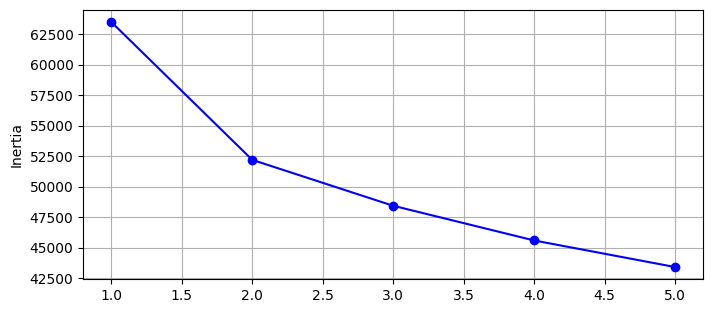

In [13]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 6), inertias_1, "bo-")
plt.xlabel("")
plt.ylabel("Inertia")
plt.grid()
plt.show()

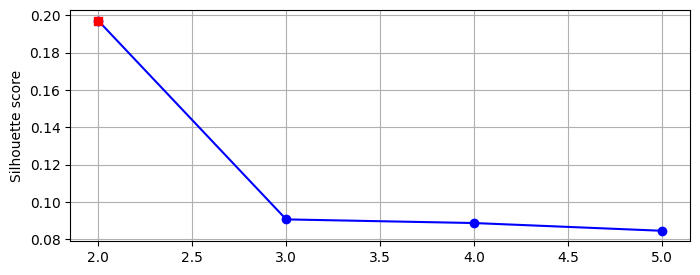

In [14]:
plt.figure(figsize=(8, 3))

k_range = range(2, 6)
best_index = np.argmax(silhouette_avgs)
best_k = k_range[best_index]
best_score = silhouette_avgs[best_index]

plt.plot(k_range, silhouette_avgs, "bo-")
plt.xlabel("")
plt.ylabel("Silhouette score")
plt.plot(best_k, best_score, "rs")
plt.grid()
plt.show()

In [15]:
# using 2 clusters using all of the data
kmeans = KMeans(n_clusters=2, random_state=42).fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
cluster_labels = kmeans.labels_

# Initialize dictionaries to store indices of data points belonging to each cluster
cluster_indices = {}
for i in range(2):  # Assuming 2 clusters
    cluster_indices[i] = []

for i, label in enumerate(cluster_labels):
    cluster_indices[label].append(y[i])


In [17]:
from collections import Counter

for key, value in cluster_indices.items():
    freq = Counter(value)
    print(key, ':', freq)


0 : Counter({'Small Cell': 43, 'Non-Small Cell': 12})
1 : Counter({'Non-Small Cell': 107, 'Small Cell': 6})


In [18]:
# using PCA to visualize the two clusters

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
labels = kmeans.labels_

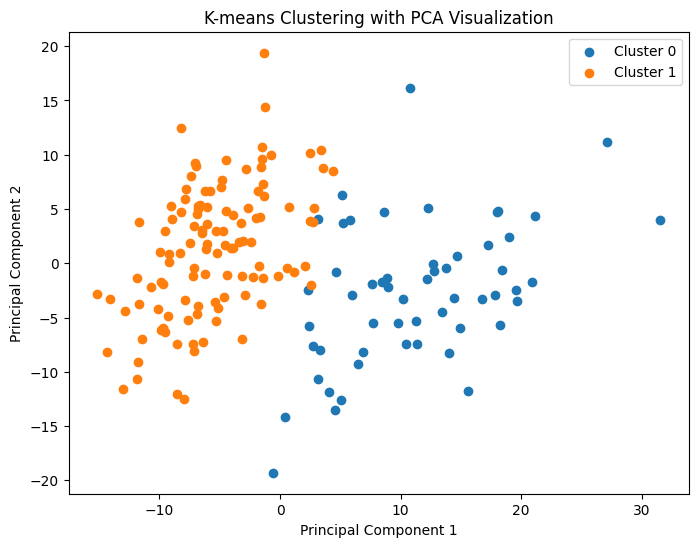

In [19]:
plt.figure(figsize=(8, 6))
x_range = (-20, 35)
y_range = (-25, 25)
for cluster_label in np.unique(labels):
    plt.scatter(X_pca[labels == cluster_label, 0], X_pca[labels == cluster_label, 1], label=f'Cluster {cluster_label}')

plt.title('K-means Clustering with PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

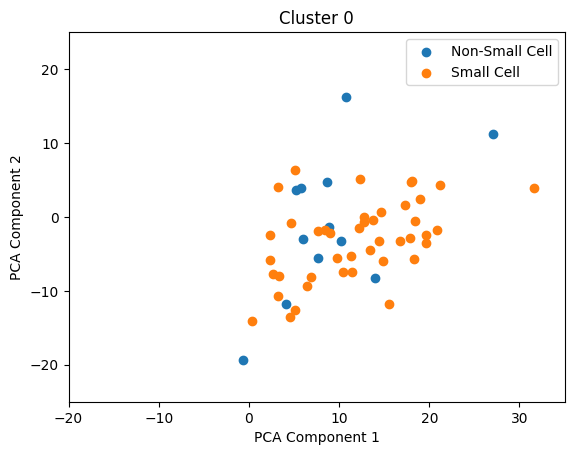

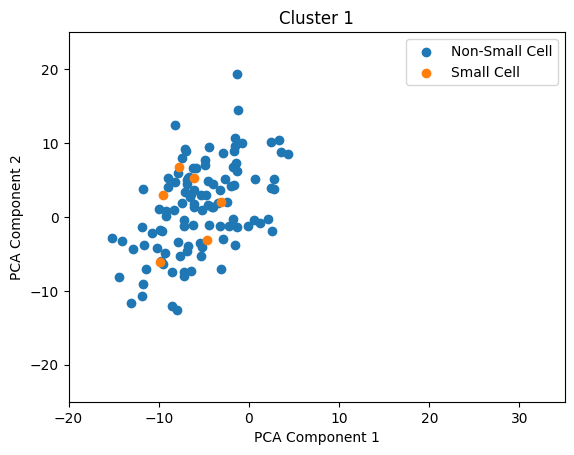

In [20]:
# Mapping classes to each cluster

x_range = (-20, 35)
y_range = (-25, 25)

unique_labels = np.unique(kmeans.labels_)

for label in unique_labels:
    plt.figure()
    plt.xlim(x_range)
    plt.ylim(y_range)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'Cluster {label}')

    indices = np.where(kmeans.labels_ == label)

    for class_label in np.unique(data['lineage']):
        class_indices = np.where(data['lineage'].values[indices] == class_label)
        plt.scatter(X_pca[indices][class_indices, 0], X_pca[indices][class_indices, 1], label=f'{class_label}')
        print()

    plt.legend()
    plt.show()

Conclusion: Using KMean Clustering, there are optimually 2 clusters as assess by the Silhouette Score, with one cluster having a mixture of Small Cell and Non-Small Lung Cancer (the majority of which are Small Cells). The other cluster is almost exclusively Non-Small Cancer cells.

## **Classification**

I will use three difference approaches to try to classify Lung Cancer Cells with the aforementioned features. I will compare performance of Logistic Regression, SVC, and RandomForest Classifier. For each approach, I will determine the optimal parameters by grid_search.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Columns: 735 entries, MIMAT0000062 to lineage
dtypes: float64(734), object(1)
memory usage: 964.8+ KB


In [22]:
# Check if any cell contains NaN
any_nan = data.isna().any().any()
any_nan

False

In [23]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.utils.class_weight import compute_class_weight

cv = 6

## **Logistic Regression**

In [27]:
from sklearn.linear_model import LogisticRegression

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

log_reg = LogisticRegression(class_weight=dict(zip(np.unique(y_train), class_weights)), max_iter=5000)
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.05, 0.1],
    'solver': ['liblinear', 'saga']
}

# Perform grid search cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=6,
             estimator=LogisticRegression(class_weight={'Non-Small Cell': 0.7052631578947368,
                                                        'Small Cell': 1.7179487179487178},
                                          max_iter=5000),
             param_grid={'C': [0.001, 0.01, 0.05, 0.1], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

In [28]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
log_best_model = grid_search.best_estimator_
cv_scores = cross_val_score(log_best_model, X_train, y_train, cv=cv)
print("Mean Cross-Validation Score:", cv_scores.mean())

Best Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Mean Cross-Validation Score: 0.8949275362318839


In [29]:
y_pred = log_best_model.predict(X_test)

In [30]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[23,  1],
       [ 2,  8]])

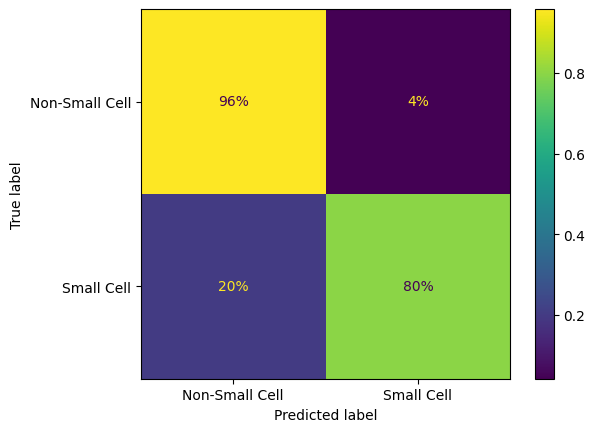

In [31]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%")

In [42]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
results_df = pd.DataFrame(report).transpose()
print(results_df)

                precision    recall  f1-score    support
Non-Small Cell   0.920000  0.958333  0.938776  24.000000
Small Cell       0.888889  0.800000  0.842105  10.000000
accuracy         0.911765  0.911765  0.911765   0.911765
macro avg        0.904444  0.879167  0.890440  34.000000
weighted avg     0.910850  0.911765  0.910343  34.000000


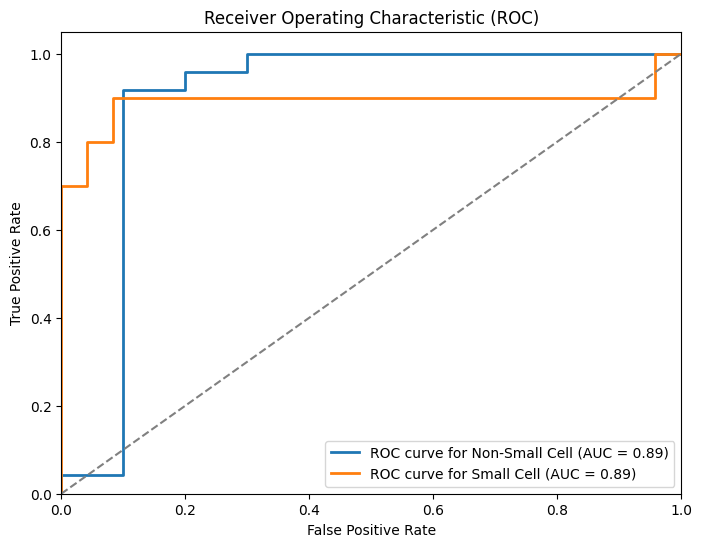

In [34]:
from sklearn.metrics import roc_curve, auc

## auc
y_prob = log_best_model.predict_proba(X_test)

class_labels = ['Non-Small Cell', 'Small Cell']

fpr = {}
tpr = {}
roc_auc = {}

for i, label in enumerate(class_labels):
    y_true = (y_test == label)
    y_score = y_prob[:, i]
    fpr[label], tpr[label], _ = roc_curve(y_true, y_score)
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure(figsize=(8, 6))
for label in class_labels:
    plt.plot(fpr[label], tpr[label], lw=2, label='ROC curve for {} (AUC = {:.2f})'.format(label, roc_auc[label]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


## **SVC**

In [35]:
from sklearn.svm import SVC

svc = SVC(class_weight='balanced', probability=True)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
}

grid_search = GridSearchCV(svc, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=6, estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             scoring='accuracy')

In [37]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

svc_best_model = grid_search.best_estimator_
cv_scores = cross_val_score(svc_best_model, X_train, y_train, cv=cv)
print("Mean Cross-Validation Score:", cv_scores.mean())

Best Hyperparameters: {'C': 1, 'gamma': 0.001}
Mean Cross-Validation Score: 0.8955862977602108


In [39]:
y_pred = svc_best_model.predict(X_test)

In [40]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[23,  1],
       [ 2,  8]])

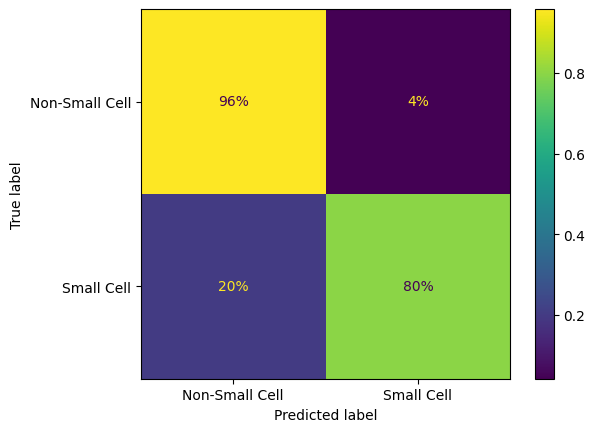

In [41]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%")

In [43]:
report = classification_report(y_test, y_pred, output_dict=True)
results_df = pd.DataFrame(report).transpose()
print(results_df)

                precision    recall  f1-score    support
Non-Small Cell   0.920000  0.958333  0.938776  24.000000
Small Cell       0.888889  0.800000  0.842105  10.000000
accuracy         0.911765  0.911765  0.911765   0.911765
macro avg        0.904444  0.879167  0.890440  34.000000
weighted avg     0.910850  0.911765  0.910343  34.000000


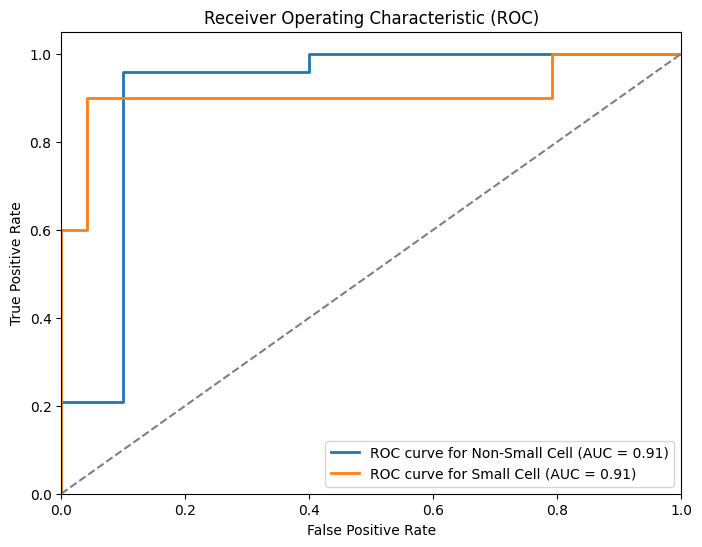

In [44]:
## auc

y_prob = svc_best_model.predict_proba(X_test)

class_labels = ['Non-Small Cell', 'Small Cell']

fpr = {}
tpr = {}
roc_auc = {}

for i, label in enumerate(class_labels):
    y_true = (y_test == label)
    y_score = y_prob[:, i]
    fpr[label], tpr[label], _ = roc_curve(y_true, y_score)
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure(figsize=(8, 6))
for label in class_labels:
    plt.plot(fpr[label], tpr[label], lw=2, label='ROC curve for {} (AUC = {:.2f})'.format(label, roc_auc[label]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

## **RandomForest**

In [45]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators': [300, 500, 800],  # Number of trees in the forest
    'max_depth': [None, 10, 20],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [2, 4, 8],     # Minimum number of samples required at each leaf node
}

# Perform grid search cross-validation
grid_search = GridSearchCV(rfc, param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [300, 500, 800]},
             scoring='accuracy')

In [46]:
# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

rf_best_model = grid_search.best_estimator_
cv_scores = cross_val_score(rf_best_model, X_train, y_train, cv=cv)
print("Mean Cross-Validation Score:", cv_scores.mean())

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Mean Cross-Validation Score: 0.8949275362318841


In [47]:
y_pred = rf_best_model.predict(X_test)

In [48]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[23,  1],
       [ 2,  8]])

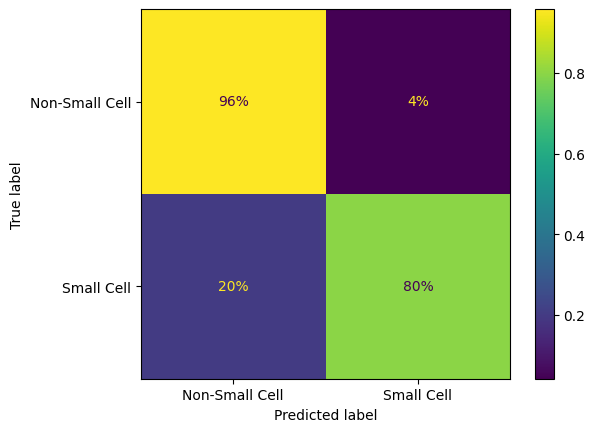

In [49]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true", values_format=".0%")

In [51]:
report = classification_report(y_test, y_pred, output_dict=True)
results_df = pd.DataFrame(report).transpose()
print(results_df)

                precision    recall  f1-score    support
Non-Small Cell   0.920000  0.958333  0.938776  24.000000
Small Cell       0.888889  0.800000  0.842105  10.000000
accuracy         0.911765  0.911765  0.911765   0.911765
macro avg        0.904444  0.879167  0.890440  34.000000
weighted avg     0.910850  0.911765  0.910343  34.000000


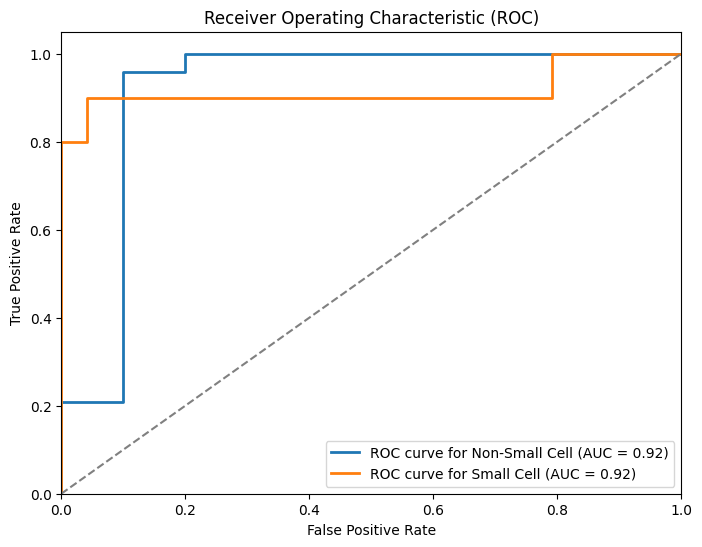

In [52]:
## auc

y_prob = rf_best_model.predict_proba(X_test)

class_labels = ['Non-Small Cell', 'Small Cell']

fpr = {}
tpr = {}
roc_auc = {}

for i, label in enumerate(class_labels):
    y_true = (y_test == label)
    y_score = y_prob[:, i]
    fpr[label], tpr[label], _ = roc_curve(y_true, y_score)
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure(figsize=(8, 6))
for label in class_labels:
    plt.plot(fpr[label], tpr[label], lw=2, label='ROC curve for {} (AUC = {:.2f})'.format(label, roc_auc[label]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

I chose three different approaches, Logistic Regression, RandomForest, and SVC.,all showed comparable result: F1 score for Non-Small Cell and Small Cell are 0.94 and 0.84, respectively.

## **Analysis of Predictive Features**

Next, I perform deeper analysis of feature that are important for segregating the two classes of Lung Cancer Cells. First we ask how many features accounts for 90% of the prediction using the RandomForest Model.

In [53]:
importances = rf_best_model.feature_importances_

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

# Cumulative sum of feature importances
cumulative_importances = np.cumsum(importances[sorted_indices])

# Find the number of features that account for 90% of prediction
num_features_90_percent = np.argmax(cumulative_importances >= 0.9) + 1

print("Of the 743 features, how many of these accounting for 90% of prediction:", num_features_90_percent)

Of the 743 features, how many of these accounting for 90% of prediction: 295


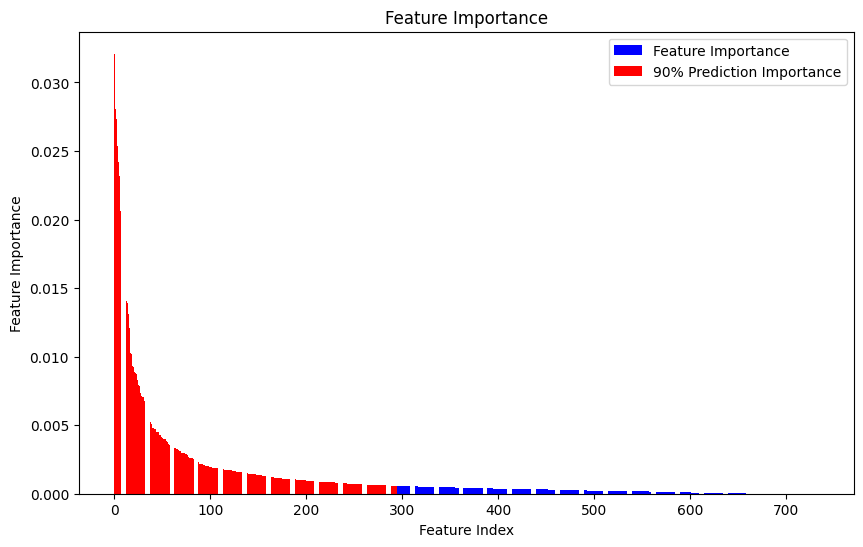

In [54]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_indices], align='center', color='blue', label='Feature Importance')

# Highlight the features that account for 90% of prediction
plt.bar(range(num_features_90_percent), importances[sorted_indices][:num_features_90_percent],
        align='center', color='red', label='90% Prediction Importance')

plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance')
plt.legend()
plt.show()

In [55]:
# rank the features by importance
feature_order_by_importance = importances[sorted_indices]
feature_order_by_importance[:10]

array([0.03209891, 0.02806761, 0.0273603 , 0.02536749, 0.02418479,
       0.02318093, 0.02066004, 0.01925152, 0.01735533, 0.01586958])

In [56]:
# top 10 features that are important
X.columns[sorted_indices][:10]

Index(['MIMAT0000078', 'MIMAT0000772', 'MIMAT0000098', 'MIMAT0000100',
       'MIMAT0000084', 'MIMAT0000086', 'MIMAT0000279', 'MIMAT0000728',
       'MIMAT0002807', 'MIMAT0000428'],
      dtype='object')

In [57]:
df = data[X.columns[sorted_indices][:10]]

In [58]:
df['target'] = y

<ipython-input-58-41140dc06108>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = y


In [59]:
df.head(3)

,MIMAT0000078,MIMAT0000772,MIMAT0000098,MIMAT0000100,MIMAT0000084,MIMAT0000086,MIMAT0000279,MIMAT0000728,MIMAT0002807,MIMAT0000428,target
0,9.523483,9.837596,6.262471,6.130931,8.630558,8.090219,6.383013,16.641300,6.383013,6.978653,Small Cell
1,8.663416,9.447909,6.209064,7.271463,9.148095,11.304745,5.913608,14.604454,6.192391,6.496015,Small Cell
2,7.546431,9.184628,6.335569,6.084489,6.225159,8.155780,7.849311,14.351975,5.997518,8.420971,Small Cell


Next, I plotted of distribution of these miRNA in each of the cell lines and compare the expression of distribution of these in the Small Cell vs Non-Small Cell groups.

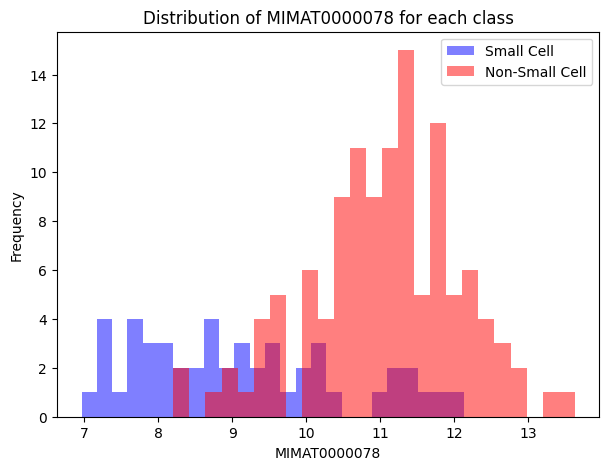

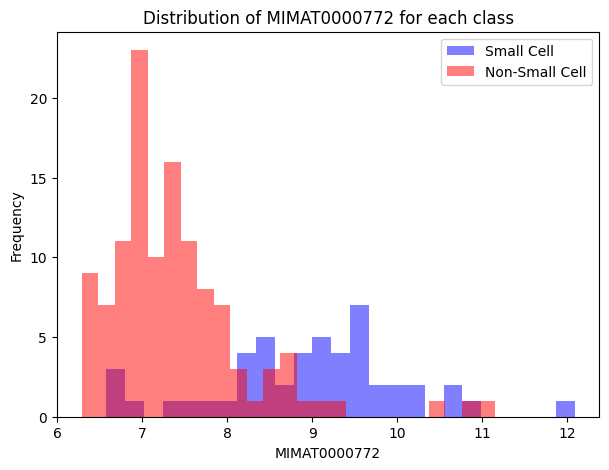

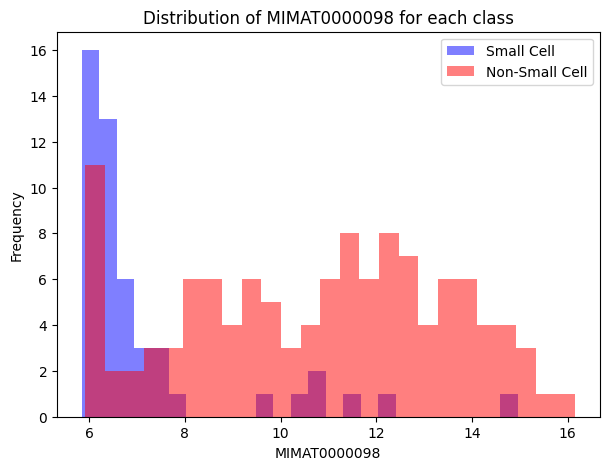

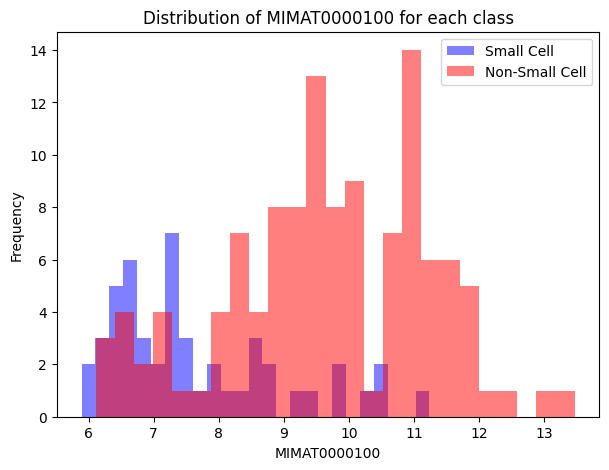

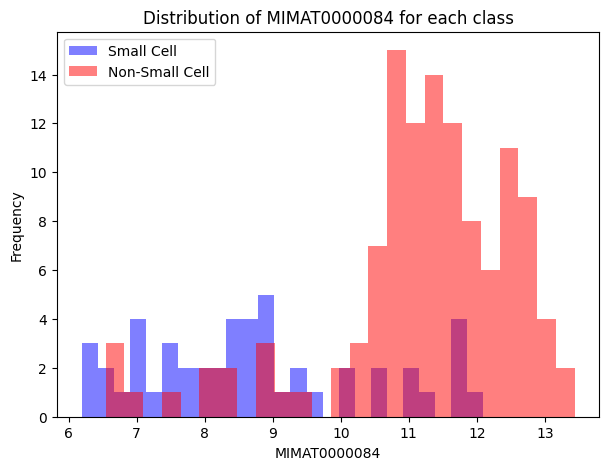

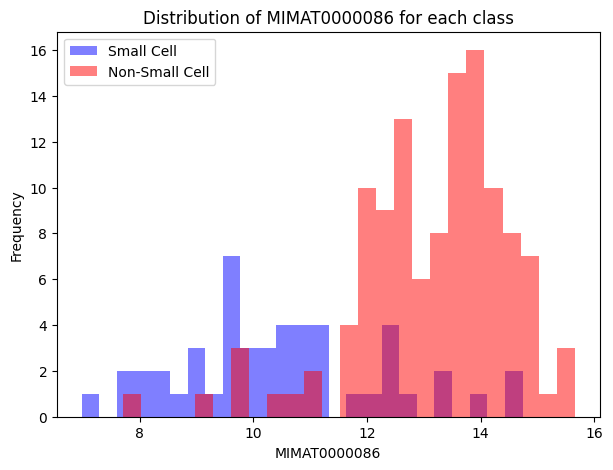

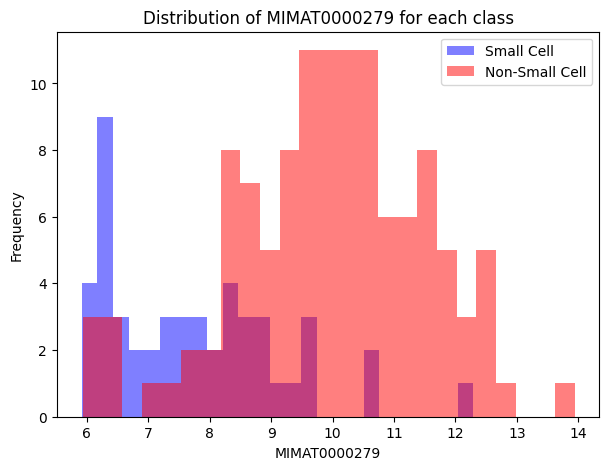

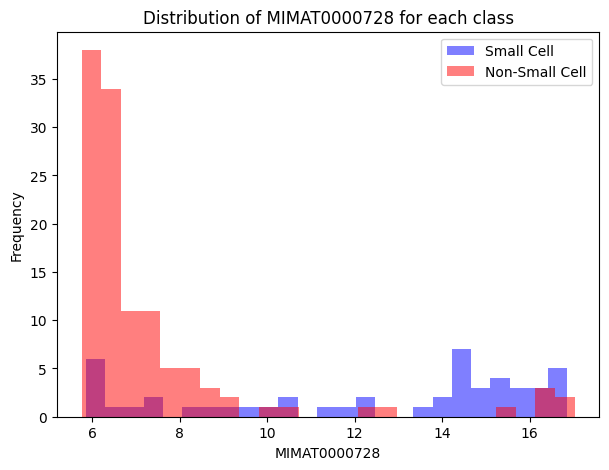

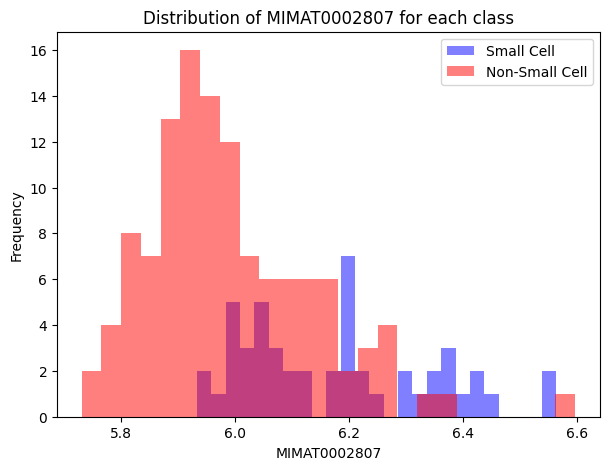

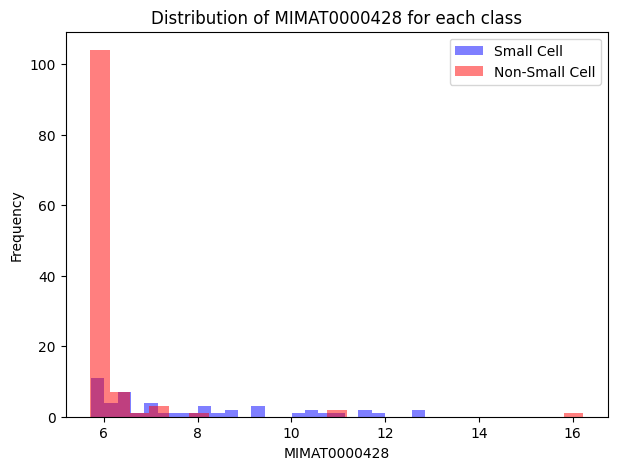

In [60]:
class_0_data = df[df['target'] == "Small Cell"].drop(columns=['target'])
class_1_data = df[df['target'] == "Non-Small Cell"].drop(columns=['target'])

# Plot histograms for each feature comparing the two classes
for feature in df.columns[:-1]:  # Exclude the target column from iteration
    plt.figure(figsize=(7, 5))
    plt.hist(class_0_data[feature], bins=25, alpha=0.5, label='Small Cell', color='blue')
    plt.hist(class_1_data[feature], bins=25, alpha=0.5, label='Non-Small Cell', color='red')
    plt.title(f'Distribution of {feature} for each class')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    print()

From miRBase (www.mirbase.org/), the corresponding miRNA for several of the miRNA Identifiier recovered above.

In [61]:
miRNA_data = {
    'MIMAT0000078' : 'hsa-miR-23a-3p',
    'MIMAT0000772' : 'hsa-miR-345-5p',
    'MIMAT0000098' : 'hsa-miR-100-5p',
    'MIMAT0000100': 'hsa-miR-375-3p',
    'MIMAT0000084' : 'hsa-mir-27a',
    'MIMAT0000086' : 'hsa-miR-29a-3p',
    'MIMAT0000279' : 'hsa-miR-222-3p',
    'MIMAT0000728': 'hsa-miR-375-3p',
    'MIMAT0002807' : 'hsa-miR-29a-3p',
    'MIMAT0000428' : 'hsa-miR-135a-5p',
}

table = pd.DataFrame(list(miRNA_data.items()), columns=['miRNA Identifier', 'miRNA'])
table

,miRNA Identifier,miRNA
0,MIMAT0000078,hsa-miR-23a-3p
1,MIMAT0000772,hsa-miR-345-5p
2,MIMAT0000098,hsa-miR-100-5p
3,MIMAT0000100,hsa-miR-375-3p
4,MIMAT0000084,hsa-mir-27a
5,MIMAT0000086,hsa-miR-29a-3p
6,MIMAT0000279,hsa-miR-222-3p
7,MIMAT0000728,hsa-miR-375-3p
8,MIMAT0002807,hsa-miR-29a-3p
9,MIMAT0000428,hsa-miR-135a-5p


Of these, hsa-miR-22-3p (MIMAT0000077) was reported to be regulated in lung adenocarcinoma [1] and it is dysregulated in NSCLC [2]. Overexpression of this miRNA may inhibit lung cancer cell proliferation, migration, and invasion through TP53, and promote cell apoptosis.

## **Conclusion**

Our analysis reveals significant differences in miRNA expression profiles between Small Cell and Non-Small Cell Lung Cancer Cell lines. Notably, one of the miRNAs have been previously implicated in key processes such as proliferation and cell survival in lung cancer. By identifying these distinct miRNA signatures, our study contributes to understanding the molecular mechanisms underlying lung tumorigenesis. These findings highlight potential targets for further investigation and therapeutic interventions aimed at combating lung cancer progression.

Reference:
1. The clinical significance and mechanism of microRNA-22-3p targeting TP53 in lung adenocarcinoma.
Lin R,  Li GS,  Gan XY,  Peng JX,  Feng Y,  Wang LT,  Zhang CY,  Huang KY,  Huang SH,  Yang L,  Kong JL,  Zhou HF,  Chen G,  Huang WY
Technol Health Care. 2023. 31(5):1691-1707.doi: 10.3233/THC-220494
2. MiR-22-3p suppresses NSCLC cell migration and EMT via targeting RAC1 expression. Xuejiao Wang, Xiaobin Wang, Tao Jiang, Zhipei Zhang, Nianlin Xie. Funct Integr Genomics. 2023; 23(3): 281.